#Mount google drives#
I used google colab as my environment to do the 2nd project.
It was really handy as all the tool chains were preinstalled.

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

%cd '/content/drive/My Drive/Colab Notebooks/Udacity/Projects/2AdvancedLaneFinding/P2/CarND-Advanced-Lane-Lines'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/
/content/drive/My Drive/Colab Notebooks/Udacity/Projects/2AdvancedLaneFinding/P2/CarND-Advanced-Lane-Lines


#Import all the necessary packages#

In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import glob
%matplotlib inline

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)1597440/45929032 bytes (3.5%)5177344/45929032 bytes (11.3%)8626176/45929032 bytes (18.8%)12189696/45929032 bytes (26.5%)15605760/45929032 bytes (34.0%)18939904/45929032 bytes (41.2%)22315008/45929032 bytes (48.6%)25698304/45929032 bytes (56.0%)29089792/45929032 bytes (63.3%)32546816/45929032 bytes (70.9%)35905536/45929032 bytes (78.2%)39288832/45929032 bytes (85.5%)

In [0]:
Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)3227648/45929032 bytes (7.0%)7299072/45929032 bytes (15.9%)11436032/45929032 bytes (24.9%)15327232/45929032 bytes (33.4%)19382272/45929032 bytes (42.2%)23404544/45929032 bytes (51.0%)27467776/45929032 bytes (59.8%)31498240/45929032 bytes (68.6%)35463168/45929032 bytes (77.2%)39518208/45929032 bytes (86.0%)43532288/45929032 bytes (94.8%)45929032/45929032 bytes (100.0%)
  Done
File saved as /root/.imageio/ffmpeg/ffmpeg-linux64-v3.3.1.


#Camera Calibration#

The main objective of the lane line detection algorithm is to find the lane lines in an image and measure its curvature so that this information can be fed back to the controllers that will then steer the vehicle by a precise angle to account for this curvature in the road ahead. 

But the image we get from the camera is not always perfect. The camera transforms what it sees in the 3D world into 2D space through some transformation and in doing so it distorts the image. Take a look at the image below. You can notice that the edges of the images are stretched outwards. Since we rely on measurements from the image to place our car in the view, the objects at the edges of the image will appear to be curved and stretched out and hence will give us the wrong measurment if this distortion is not corrected.

Below image shows the distored images taken out of the camera. 
![radial and tangential distorted image](https://drive.google.com/uc?id=1fZRQh_x_QTYpD_m75eRQtYukrlWshOci)

As the first step we need to calibrate the camera for which it is always a practise to take the image of standard pattern like chess board.
First we find the chess board corners and OpenCV functions findChessboardCorners() and drawChessboardCorners() to automatically find and draw corners in an image of a chessboard pattern.
Then we use calibrateCamera function to calibrate the camera and get the camera matrix.
As the last step we use undistort function where we pass the camera matrix to undistort a given image.
![alt text](https://drive.google.com/uc?id=1a-USchIKCr5hRZlSXx4I6GOsoZTWTQa_)

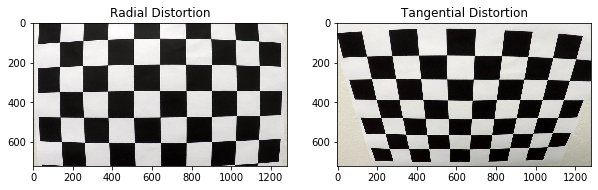

In [4]:
fig, ax = plt.subplots(1,2, figsize=(10, 7))
image = 'camera_cal/calibration1.jpg'
img = cv2.imread(image)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

ax[0].imshow(img) 
ax[0].set_title('Radial Distortion')


image = 'camera_cal/calibration2.jpg'
img = cv2.imread(image)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

ax[1].imshow(img) 
ax[1].set_title('Tangential Distortion')
plt.show() 

# Distortion Correction#

![radial and tangential distorted image](https://drive.google.com/uc?id=1fZRQh_x_QTYpD_m75eRQtYukrlWshOci)

There are broadly two types of distortions. The first image above is termed as **radial distortion** where the edges are stretched out or rounded. This is mostly caused because of the fact that the light bends either too much or too little at the edges of the lens causing the objects in the edges to be curved more or less than they actually are. 

The second type of distortion is **tangential distortion** as seen in the second image above. This is uaually caused when the plane of the lens is not aligned with the plane of the image sensor in the camera. In this case the objects appear father away or closer than they actually are.  

In order to correct these two types of distortions, we can use a calibration technique where in we capture standard shapes from the camera and compare its location with an undistorted image. The commonly used pattern for this purpose is a chessboard pattern where we can detect the corners in the image and come up with a transformation that projects the detected corners from the distorted space to the undistorted space. 

<center><img src="https://docs.google.com/uc?export=download&id=1RQQf7Rj3jn8rv16dg1mv3wgGnr8k5EV2" width=500 /> </center>

[Source: Camera calibration openCV](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_calib3d/py_calibration/py_calibration.html)

### Radial Distortion Correction

<center>

![eq1](https://latex.codecogs.com/gif.latex?%24%24%20x_%7Bdistorted%7D%20%3D%20x_%7Bideal%7D%281&plus;k_1%20r%5E2%20&plus;%20k_2%20r%5E4%20&plus;%20k_3%20r%5E6%29%20%24%24)

![eq2](https://latex.codecogs.com/gif.latex?%24%24%20y_%7Bdistorted%7D%20%3D%20y_%7Bideal%7D%281&plus;k_1%20r%5E2%20&plus;%20k_2%20r%5E4%20&plus;%20k_3%20r%5E6%29%20%24%24)
  
</center>



### Tangential Distortion Correction

<center>
  
![eq3](https://latex.codecogs.com/gif.latex?%24%24%20x_%7Bcorrected%7D%20%3D%20x%20&plus;%20%5B2p_1%20xy%20&plus;%20p_2%28r%5E2%20&plus;%202x%5E2%29%5D%20%24%24)

![eq4](https://latex.codecogs.com/gif.latex?%24%24%20y_%7Bcorrected%7D%20%3D%20y%20&plus;%20%5B2p_1%28r%5E2%20&plus;%202y%5E2%29%20&plus;%202p_2xy%5D%20%24%24)
  
</center>

These transformation coefficients ( $ k_1, k_2, k_3, p_1, p_2 $) , along with the camera matrix 
<center>

![eq5](https://latex.codecogs.com/gif.latex?%24%24%20camera%5C%20matrix%20%3D%20%7B%5Cbegin%7Bbmatrix%7D%20f_x%20%26%200%20%26%20c_x%20%5C%5C%200%20%26%20f_y%20%26%20c_y%5C%5C%200%20%26%200%20%26%201%5C%5C%20%5Cend%7Bbmatrix%7D%20%7D%24%24)

</center>

can then be used to undistort every frame that we extract from the camera feed. Here $c_x and \ c_y $ are principal points which is usually the image center and ***f_x***  and ***f_y*** are the focal length expressed in pixels. The camera matrix is intrinsic to a camera.

In oder to get these parameters we can use OpenCV function ```cv2.calibrateCamera``` . This function needs the object points and the image points as inputs. The **object points** are the coordinates of the corners in the undistorted image and **image points** are the actual coordinates as captured by the camera.

`ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)`

To get the image points we can use ```cv2.findChessboardCorners``` function which takes in a gray scale image of the image and returns the coordinates of the corners.

`ret, corners = cv2.findChessboardCorners(gray, (8,6), None)`
![alt text](https://drive.google.com/uc?id=1dLixkBfFykeoNMEkGioNPtA8E21h7iUA)


Calibration is usually done using more than 20 images taken from the camera. For every image the detected **image points**  are appended to an **image points** array. The **object points** remains the same for all the images. The returned **camera \ matrix** and **distortion \ coefficients** are the used to undistort the image using ```cv2.undistort```

**Below are the steps taken.**
1. Convert to grayscale.
    >gray = cv.cvtColor(img,cv2.COLOR_BGR2GRAY)
2. Find corners in the image (Draw corners if wanted to visualize)
    >ret, corners = cv2.findChessboardCorners(gray, (8,6), None)
    >img = cv2.drawChessboardCorners(img, (8,6), corners, ret)
3. Camera calibration for given object points, image points, and shape of the graysale image.
    >cv2.calibrateCamera(objectPoints, imagePoints, imageSize[, cameraMatrix[, distCoeffs[, rvecs[, tvecs[, flags[, criteria]]]]]]) 
    → retval, cameraMatrix, distCoeffs, rvecs, tvecs
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
4. Undistort the image
    >cv2.undistort(src, cameraMatrix, distCoeffs[, dst[, newCameraMatrix]]) → dst
    dst = cv2.undistort(img, mtx, dist, None, mt


In [0]:
import pickle
camera_cal = pickle.load( open( "pickle/cal.p", "rb" ) )

mtx = camera_cal["mtx"]
dist = camera_cal["dist"]

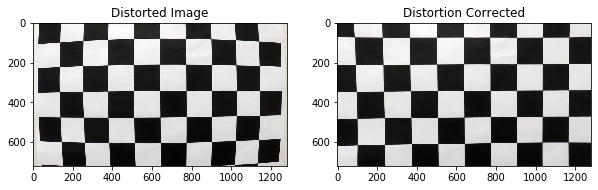

In [6]:
fig, ax = plt.subplots(1,2, figsize=(10, 7))
image = 'camera_cal/calibration1.jpg'
img = cv2.imread(image)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

ax[0].imshow(img) 
ax[0].set_title('Distorted Image')
dst = cv2.undistort(img, mtx, dist, None, mtx)

ax[1].imshow(dst) 
ax[1].set_title('Distortion Corrected')
plt.show() 

# Binary Thresholding#

Generally both the approaches Gradient and color thresholding are used in combination to extract the lane lines correctly from the images so the effects of external factors such as shadows, lights, colors could be minimized.



##Garadient Thresholding##
**Sobel operator**
It is used to find edges in an image by taking derivative of the image in thh x or y direction to highlight the vertical or horizontal line respectively.

![Curved lane](https://drive.google.com/uc?id=1tevEGQ3vJUh2tAyHVRw_lM3AmTeOnPnm)
![sobel operation](https://drive.google.com/uc?id=157Du5cUYJWCjped-mSjiHkoy6ysEcoe6)
In the above images, you can see that the gradients taken in both the xx and the yy directions detect the lane lines and pick up other edges. Taking the gradient in the xx direction emphasizes edges closer to vertical. Alternatively, taking the gradient in the yy direction emphasizes edges closer to horizontal.

To get the optimized results - it is often a practice to take the magnitude of the gradient which is the square root fo the sum of the squares of the xx and yy gradient.
  >abs_sobelx= $\sqrt{(sobel_x)^2}$ \
  abs_sobely= $\sqrt{(sobel_y)^2}$  \
  abs_sobelxy= $\sqrt{(sobel_x)^2 + (sobel_y)^2}$  \
  


##Color thresholding##  
Lane lines can be either yellow or white in color. Instead of the standard RGB color space, HLS color space is more effective in isolating the lane lines. 
![alt text](https://drive.google.com/uc?id=11B7R1g9UoLBFqQ4WIVwKA7VWyqPCSweA)

In the below image - image has ben converted to gray before doing binary thresholding.
![alt text](https://drive.google.com/uc?id=1QxR3tZYqzbGhfZYYsNaLYr7AbnzbWxBD)

Simiarly the below image first splitted into R channel before doing binary threshoding and no doubt results are markedely better.
![alt text](https://drive.google.com/uc?id=1Zz7OVfGzRc1BRW3YiLgU3yuAc1bU3ewq)

Results are often better if we convert the image from RGB to HLS color space as the effect due to color tint could be minized as happens due to changes in brightness and shadow. So if you imagine a basic red paint color, then add some white to it or some black to it will make that color lighter or darker; however, the underlying color remains the same and the hue for all of these colors will be the same.
![alt text](https://drive.google.com/uc?id=1wiPy0bqpVgrjYuQe_--Bjc01cloJcOZv)

As seen in the above image the sturation channel highlights the bright lane lines, compared to the surrounding darker road, better than the other two channels. 

Hence in this pipeline, the next step will be to convert the image to HLS and use the S channel for lane detection.

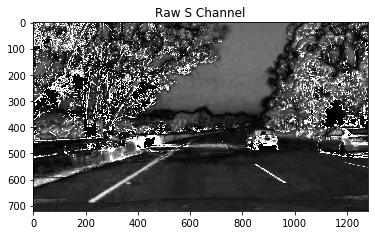

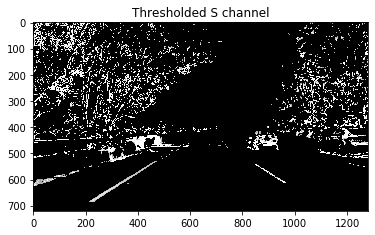

In [7]:
image = 'test_images/test5.jpg'
img = cv2.imread(image)
hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
s_channel = hls[:,:,2]
plt.imshow(s_channel,cmap='gray')
plt.title('Raw S Channel')
plt.show()

s_channel[(s_channel > 0) & (s_channel < 160) ] = 0
plt.imshow(s_channel,cmap='gray')
plt.title('Thresholded S channel')
plt.show()


In the above code block, the second image above is a thresholded image where the S channel is thresholded such that all pixels below an intesity value of 160 is set to zero. The third image is a binary image created from the thresholded image. Any pixel with an intensity higher than zero is set to one. 


##Combining Gradient and Color thresholding##
At this point, it's okay to detect edges around trees or cars because these lines can be mostly filtered out by applying a mask to the image and essentially cropping out the area outside of the lane lines. It's most important that you reliably detect different colors of lane lines under varying degrees of daylight and shadow.

You can clearly see which parts of the lane lines were detected by the gradient threshold and which parts were detected by the color threshold by stacking the channels and seeing the individual components. You can create a binary combination of these two images to map out where either the color or gradient thresholds were met.
![alt text](https://drive.google.com/uc?id=1CsxvwwvJ4qHDpTewDUjNW-fG202NDBjr)


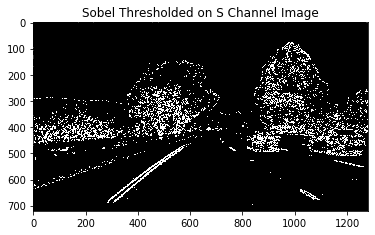

In [9]:
thresh = [10,255]
image = 'test_images/test1.jpg'
img = cv2.imread(image)
hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
s_channel = hls[:,:,2]
sobelx = cv2.Sobel(s_channel,cv2.CV_64F,1,0,ksize=3)
scaledx = np.abs(255*sobelx/np.max(sobelx)).astype('uint8')
binaryx = np.zeros_like(scaledx)
binaryx[(scaledx > thresh[0]) & (scaledx <= thresh[1])] = 1
sobely = cv2.Sobel(s_channel,cv2.CV_64F,0,1,ksize=3)
scaledy = np.abs(255*sobely/np.max(sobely)).astype('uint8')
binaryy = np.zeros_like(scaledy)
binaryy[(scaledy > thresh[0]) & (scaledy <= thresh[1])] = 1

combined = np.zeros_like(scaledy)
combined[(binaryx == 1) & (binaryy == 1)] =1
plt.imshow(combined,cmap='gray')
plt.title('Sobel Thresholded on S Channel Image')
plt.show()


#Perspective Transform#

In an image captured by a camera, objects that are farther away from the camera look smaller as cmpared to the ones closer to the camera. Also parallel lane lines appear to converge at a point. This phenomena is caller ***Perspective***. The curvature of the lanes cannot be measured from the raw image directly since the two lines will have different curvatures and doesnt seem to be parallel in this view. Hence this image needs to be projected to a view where the lines appear to be parallel to each other. This projection is called **Perspective Transformation** . 

In order to perform perspective transformation we need to define source and destination points on the raw image and the transformed image. The example images below show the transformation in action

Straight edges:
![alt text](https://drive.google.com/uc?id=1K2IJhYN4qpapImwZok58K96ZHR5dNwQM)

Curved edges:
![alt text](https://drive.google.com/uc?id=1SiZ0qp-qseTX79k92f03NNzNVWyCL9-w)

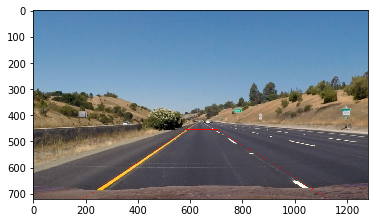

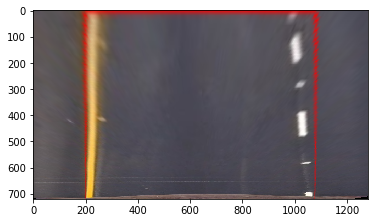

In [10]:
img_size = (img.shape[1], img.shape[0])
leftupperpoint  = [585,455]
rightupperpoint = [705,455]
leftlowerpoint  = [190,720]
rightlowerpoint = [1130,720]
    
src = np.float32([leftupperpoint,rightupperpoint,
                  rightlowerpoint,leftlowerpoint])

dst = np.float32([[200,0],[img_size[0]-200,0], [img_size[0]-200,img_size[1]],[200,img_size[1]]])


image = 'test_images/straight_lines1.jpg'
img = cv2.imread(image)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
pts = np.int32(src).reshape((-1,1,2))
cv2.polylines(img,[pts],True,(255,0,0),1)

undistort = cv2.undistort(img, mtx, dist, None, mtx)

plt.imshow(img)
plt.show()

M = cv2.getPerspectiveTransform(src, dst)
warped = cv2.warpPerspective(undistort, M, img_size)
plt.imshow(warped)
plt.show()

# Lane Line Detection

Once we have a warped binary image from the perspective transform, the left and right lines can be detected easily using the image histograms. 
In the image below we can see a plot of the histogram of the activated pixels along the x-axis. There are clearly two peaks indicating the presence of two lane lines.

##Build the pipeline for each image ##
1. Compute the camera calibration matrix and distortion coefficients. 
2. Apply them to undistort each new frame. 
3. Apply thresholds to create a binary image 
4. Apply a perspective transform.

**Orginal image:**
![alt text](https://drive.google.com/uc?id=1H-ZY-yQSSAYlPFogASKhlxibkLNo8fWu)

**Undistort image:**
![alt text](https://drive.google.com/uc?id=1E_m-jBaJqyBDQGYJyqVbDhi8p2Lh47bg)

**Binary thresholding:**
![alt text](https://drive.google.com/uc?id=1-8NnVSq0x7z5TJL2VJldR2QwhPoxN3MX)

**Perspective Transformation:**
![alt text](https://drive.google.com/uc?id=1U6QmyOBFnEVsB2SLENDmJBqiPdgrEoOT)


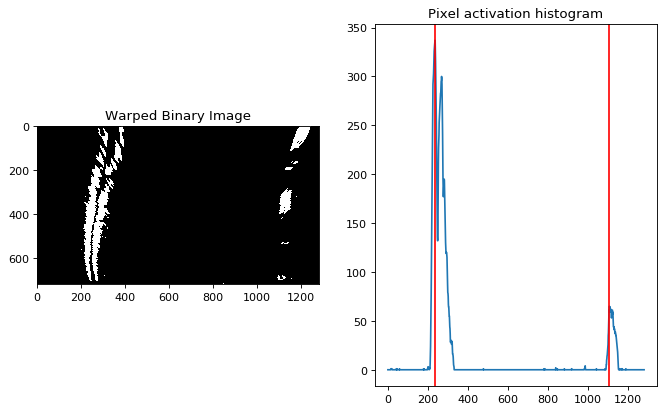

In [11]:
fig,axs = plt.subplots(1, 2,figsize=(10, 6), dpi=80)
warped = cv2.warpPerspective(combined, M, img_size)
axs[0].imshow(warped,cmap='gray')
axs[0].set_title("Warped Binary Image")

histogram = np.sum(warped[warped.shape[0]//2:,:], axis=0)
midpoint = np.int(histogram.shape[0]//2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

axs[1].plot(histogram)
axs[1].set_title("Pixel activation histogram")
axs[1].axvline(x=leftx_base,color='r')
axs[1].axvline(x=rightx_base,color='r')
plt.show()

##Locate the Lane Lines - Peaks in a Histogram##
After applying calibation thresholding, and a perspecive transform to a road image, you should have a binary image where lane lines stands out distinctly. however, we still need to define which pixels are part of the lines and which one belong to the left and which belong to the right line. One way could be plotting the historgram where the binary activation occurs across the image.

![alt text](https://drive.google.com/uc?id=13G_53EyQJ6EtMQ_w7c8TmDVcfJaH0OUT)



##Implementing sliding Windows and Fit a Polynomial##

But instead of taking the histogram for the whole image, if we can slide a window from the bottom of the image to the top, we can find the base_x values of the left and right lines along the y axis by looking at the point on x axis which has the highest activations. If the number of pixels in this window exceeds a **minpix** value then the center of the window is recomputed. In the image below we can see the sliding window and the base points of each window. We can then fit a second order polynomial to these points and get the left and right lines drawn in yellow below 

![alt text](https://drive.google.com/uc?id=1UN21YQi1lPPrzHt0CLnMEx8pnTibfvMF)

1. Split the historgram for the two lines
>Take a historgram of the bottom half of the image.\
Create an output image to draw on and visualize results (for reference).\
Find the peak of the left and right halves of the historgram


2. Set up sliding widnow (define widnow hyperparameters)
>Choose the number of sliding windows. \
Deine width, height of the sliding window.
Define hpyer parameters - minimum number of pixels requried to recenter the sliding window. \

3. Loop/Iterate through widnows to track curvature.
>Find the boundaries of oru current window. \
Find out th number pixels which falls into the window.\
Recenter window based on nunber of pixels falling in thh widnow are greater than the hyper parameters.

4. Fit a polynomial
>Once we have found all our pixels belonging to each lien through the sliding widnow method. \Concatenate the array of indices. \
Extract left and right line pixel positions. \
Use np.polyfit to fit the curve.


## Computing radius of curvature##

Once we hae found the line, we can serach in a margin around the previous lane line position (or targeted search) to track the images in a video since the lane lines doesn't necessarily moves much. Kind of doing customized region of interest for each frame of video -- way to track the lanes through sharp curves and tricky conditions. Just in case if we lose track o the lines - we can go back our sliding widnows search to rediscover them.


The radius of curvature of the fitted lines can be computed using the formula
<center>
  
![eq6](https://latex.codecogs.com/gif.latex?%24%24%20R_%7Bcurve%7D%20%3D%20%5Cfrac%7B1&plus;%282Ay&plus;B%29%5E2%29%5E%5Cfrac%7B3%7D%7B2%7D%7D%7B%7C2A%7C%7D%20%24%24)

</center>
 
Here A and B are the coefficients of the fitted curve. The equation is evaluated at the lowest part of the image , i.e  y = image.shape[0] in order to get the curvature closest to the vehicle. 

There are two curvature values that we get, the left line curvature and the right line curvature. The two are averaged and the mean radius of curvature of the lane is reported. 

<center>
  
![eq7](https://latex.codecogs.com/gif.latex?%24%24%20R_%7Bcurvature%7D%20%3D%20%5Cfrac%7BLeftLane_%7Bcurvature%7D%20&plus;%20RightLane_%7Bcurvature%7D%7D%7B2%7D%20%24%24)
  
  </center>

The distance from the center of the lane is computed by subtracting the lane center from the image center as shown below

<center>

![eq8](https://latex.codecogs.com/gif.latex?%5Cbegin%7Balign*%7D%20Lane%20center%20%3D%20LeftBase_x%20&plus;%20%28RightBase_x%20-%20LeftBase_x%29%20%5C%5C%20Image%20Center%20%3D%20image.shape%5B1%5D//2%20%5C%5C%20Distance%20from%20Center%20%3D%20%28Image%20Center%20-%20Lane%20Center%29%20*%203.7/700%20%5Cend%7Balign*%7D)

</center>

<center><img src="https://docs.google.com/uc?export=download&id=1yMbr6WTTtflDFDa2sOqmX_gzNUUZL172" width=600 /></center>



# Results#


[Output Video](https://drive.google.com/open?id=1Xuiga65XmQnASoFloXuZA1Cvcrf4UjOm)
<video src="https://drive.google.com/uc?id=1Xuiga65XmQnASoFloXuZA1Cvcrf4UjOm" width="320" height="200" controls preload></video>

 

In [12]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('output_videos/project_video_output.mp4','rb').read()

data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width="960" height="540" controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

Output hidden; open in https://colab.research.google.com to view.

# Discussion# 
1. There is still a slight flicker in the polygon at locations where the lane lines are not seen in the current frame. This probably can be addressed by reproducing the previous lane line where none is found. For shortage of time, that is not implemented in this solution.
2. The thresholding parameters are not fully tuned yet. The same code on the challenge video performs very poorly since the change in the hue is very marked in that video. Again, this is something I intend to work on at a later stage.
3. The overall run time of the pipeline was also something that prevents it from being able to be used in realtime lane line identification.